## Set environment

In [46]:
import numpy as np
import pandas as pd
import io
import esm
import argparse
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import open_close_scan
char_map = {'A': 'T',
            'G': 'C',
            'C': 'G',
            'T': 'A',}
value_map = {'A': 0,'C':1,'G':2,'T':3}
window_size = 20

## Load data

In [47]:
sseq_LMNA = None
sscount_file = 'D:/CODE/BIO/dataset/ASO/LMNA_sscount1.txt' # ss-count result from mFold

with open(sscount_file, 'r') as fp:
    cnt = fp.readline()
    data = fp.readlines()
    print('read {} lines from sscount file'.format(len(data)))
    value = []
    sequence = []
    for line in data:
        sp = line.split()
        value.append(int(sp[1])/int(cnt))
        if sp[2] == 'U':
            sp[2] = 'T'
        sequence.append(sp[2])
    sseq_LMNA = open_close_scan.Seq(sequence, value)
sseq_LMNA.open_threshold = 0.5

read 1995 lines from sscount file


In [48]:
input_file = 'D:/CODE/BIO/dataset/ASO/LMNA.csv'
df = pd.read_csv(input_file)
df.columns = ['seq','inhibition','nm']
# df = df[['seq','inhibition']]
df.head()

,seq,inhibition,nm
0,GGGCTCTGGGCTCCTGAGCC,3,75
1,CCGAGCTGCTGCAGTGGGAG,42,75
2,GCAGGTCCCGCACAGCACGG,61,75
3,TGGCAGATGCCTTGTCGGCA,21,75
4,GAGCCGCTGGCAGATGCCTT,24,75


## Feature definition
LMNA_pos : Start position of the ASO on mRNA LMNA. If ASO can not match with LMNA, the value is -1.

LMNA_open_ratio : Open ratio of the area that ASO matched with LMNA. -1 if unmatched.

LMNA_open_len : Max length of contiguous 'open' bp of the area. -1 if unmatched.

cg_ratio : percentage of CG

posi : number of 'positive' special subsequence

nega : number of 'negative' special subsequence


In [49]:
class FeatureCalc:
    @staticmethod
    def match_pos(df,seq:open_close_scan.Seq):
        rev_str = open_close_scan.get_ASO(df['seq'])
        # print(seq.str)
        # print(rev_str)
        start = seq.str.find(rev_str)
        return start
    
    @staticmethod
    def match_open_ratio(df,col,seq:open_close_scan.Seq):
        if df[col]>=0:
            st = df[col]
            ed = st + len(df['seq'])
            open_ratio = np.sum(seq.value[st:ed] >= seq.open_threshold) / (ed-st)
            return open_ratio
        else:
            return -1
    @staticmethod
    def match_open_len(df,col,seq:open_close_scan.Seq):
        if df[col]>=0:
            st = df[col]
            ed = st + len(df['seq'])
            open_len = seq.calc_contiguous_opening_len(st,ed)
            return open_len
        else:
            return -1
    pass

In [50]:
def check_cg_ratio(df):
    cnt = 0
    for ch in df['seq']:
        if (ch =='C') or (ch=='G'):
            cnt += 1
    return cnt / len(df['seq'])

def check_tm(df):
    cnt = 0
    for ch in df['seq']:
        if (ch =='C') or (ch=='G'):
            cnt += 1
    Tm = 4 * cnt + 2 * (len(df['seq']) - cnt)
    return Tm

def check_subword(df,_esm):
    cnt = len(_esm.query(df['seq']))
    return cnt

def get_value(df,k):
    return value_map[df['seq'][k]]

def get_base_count(df,target):
    cnt = 0
    for ch in df['seq']:
        cnt += (ch == target)
    return cnt

def pre_process(df):
    # for i in range(window_size):
    #     df.loc[:,'loc'+str(i)] = df.apply(get_value,k=i,axis=1)
    for key in value_map.keys():
        df.loc[:,'num_'+str(key)] = df.apply(get_base_count,target=key,axis=1)
    df.loc[:,'cg_ratio'] = df.apply(check_cg_ratio,axis=1)
    df.loc[:,'tm'] = df.apply(check_tm,axis=1)
    #
    df.loc[:,'LMNA_pos'] = df.apply(FeatureCalc.match_pos,seq=sseq_LMNA,axis=1)
    df.loc[:,'LMNA_open_ratio'] = df.apply(FeatureCalc.match_open_ratio,seq=sseq_LMNA,col='LMNA_pos',axis=1)
    df.loc[:,'LMNA_open_len'] = df.apply(FeatureCalc.match_open_len,seq=sseq_LMNA,col='LMNA_pos',axis=1)
    #initialize esm
    POSITIVE_SEQ = ['CCAC', 'TCCC', 'ACTC', 'GCCA', 'CTCT']
    NEGATIVE_SEQ = ['GGGG', 'ACTG', 'TAA', 'CCGG', 'AAA']
    positive_index = esm.Index()
    for word in POSITIVE_SEQ:
        positive_index.enter(word)
    positive_index.fix()
    negative_index = esm.Index()
    for word in NEGATIVE_SEQ:
        negative_index.enter(word)
    negative_index.fix()
    df.loc[:,'posi'] = df.apply(check_subword,_esm=positive_index,axis=1)
    df.loc[:,'nega'] = df.apply(check_subword,_esm=negative_index,axis=1)
    #
    return df


## Data prepare

In [51]:
def k_fold(k,id,data,index=None):
    size = df.shape[0]
    block = size//k
    if index is None:
        index = list(range(0,size))
    train_idx = index[0:id*block] + index[(id+1)*block:]
    test_idx = index[id*block:(id+1)*block]
    train = data.loc[train_idx]
    test = data.loc[test_idx]
    return train,test

In [52]:
df = pre_process(df)
x_column = []
for i in range(6,16):
    x_column.append('loc'+str(i))
print(df.head())
df.to_csv('debug.csv')

                    seq  inhibition  nm  num_A  num_C  num_G  num_T  cg_ratio  \
0  GGGCTCTGGGCTCCTGAGCC           3  75      1      7      8      4      0.75   
1  CCGAGCTGCTGCAGTGGGAG          42  75      3      5      9      3      0.70   
2  GCAGGTCCCGCACAGCACGG          61  75      4      8      7      1      0.75   
3  TGGCAGATGCCTTGTCGGCA          21  75      3      5      7      5      0.60   
4  GAGCCGCTGGCAGATGCCTT          24  75      3      6      7      4      0.65   

   tm  LMNA_pos  LMNA_open_ratio  LMNA_open_len  posi  nega  
0  70        -1            -1.00             -1     1     0  
1  68      1700             0.25              2     0     0  
2  70      1753             0.10              1     1     0  
3  64      1781             0.35              5     0     0  
4  66      1788             0.20              2     0     0  


## feature checking

Box plot of inhibiton grouped by 'nm'.

We can see that '100nm' group have higher average inhibiton

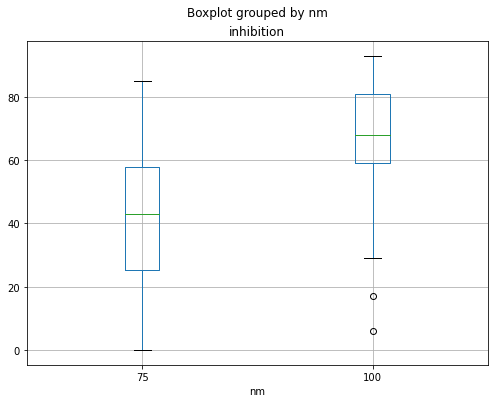

In [53]:
df_tmp = pd.DataFrame(df[['nm','inhibition']])
df_tmp.boxplot('inhibition',by='nm',figsize=(8,6))
plt.show()

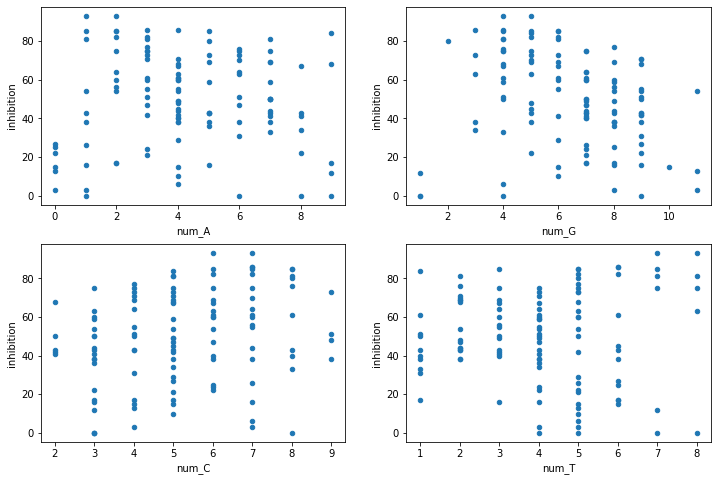

In [54]:
fig,axes = plt.subplots(2,2,figsize=(12,8))
df.plot.scatter(x='num_A',y='inhibition',ax=axes[0,0])
df.plot.scatter(x='num_G',y='inhibition',ax=axes[0,1])
df.plot.scatter(x='num_C',y='inhibition',ax=axes[1,0])
df.plot.scatter(x='num_T',y='inhibition',ax=axes[1,1])
plt.show()

### CG_Ratio
关于"CG碱基对所占比例","Tm temperature"和inhibition关系的散点图

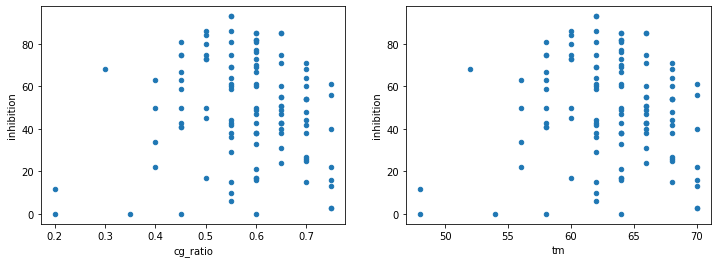

In [55]:
fig,axes = plt.subplots(1,2,figsize=(12,4))
df_tmp = pd.DataFrame(df)
df_tmp.plot.scatter(x='cg_ratio',y='inhibition',ax=axes[0])
df_tmp.plot.scatter(x='tm',y='inhibition',ax=axes[1])
plt.show()

In [56]:
df_tmp = pd.DataFrame(df)

plt.show()

### Special subsequence

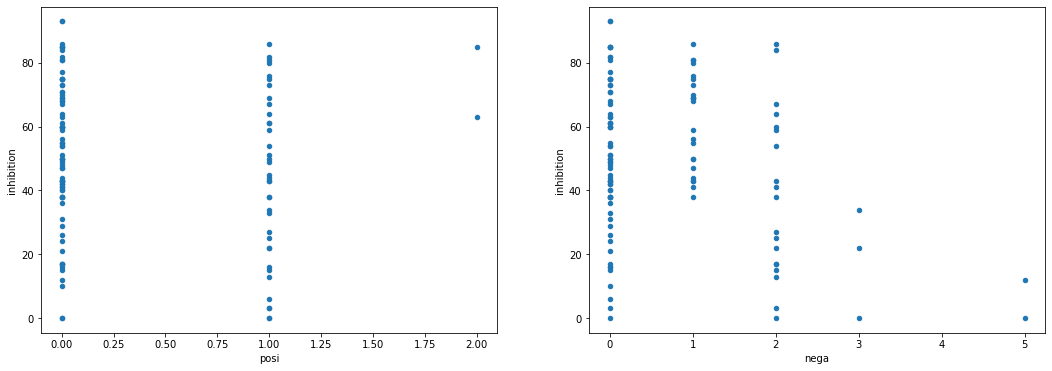

In [57]:
fig,axes = plt.subplots(1,2,figsize=(18,6))
df_tmp = pd.DataFrame(df)
df_tmp.plot.scatter(x='posi',y='inhibition',ax=axes[0])
df_tmp.plot.scatter(x='nega',y='inhibition',ax=axes[1])
plt.show()

### Feature on LMNA
position, open ratio, open len

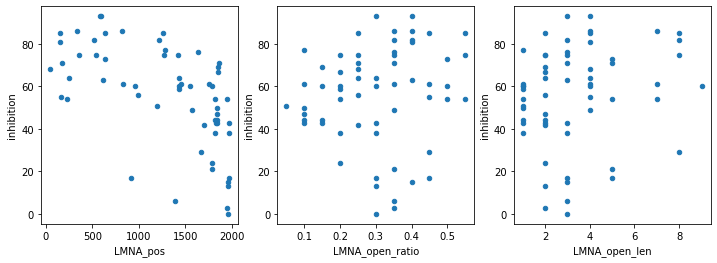

In [58]:
fig,axes = plt.subplots(1,3,figsize=(12,4))
df_tmp = pd.DataFrame(df[df['LMNA_pos']>-1])
df_tmp.plot.scatter(x='LMNA_pos',y='inhibition',ax=axes[0])
df_tmp.plot.scatter(x='LMNA_open_ratio',y='inhibition',ax=axes[1])
df_tmp.plot.scatter(x='LMNA_open_len',y='inhibition',ax=axes[2])
plt.show()

### try filt

Try filting all data that:(matches with LMNA, higher open ratio, higner open len)
The result is following. We get an average inhibiton value at about 60%

D:\anaconda3\envs\ai\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


Ttest_indResult(statistic=-1.0657213151442135, pvalue=0.28987997886346434)

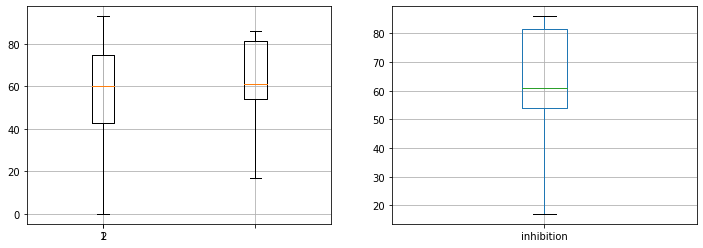

In [71]:
fig,axes = plt.subplots(1,2,figsize=(12,4))
df_tmp = pd.DataFrame(df[df['LMNA_pos']>-1])
df_tmp1 = df_tmp[df_tmp['LMNA_open_ratio']>0.3]
df_tmp1 = df_tmp1[df_tmp['LMNA_open_len']>=4]
# df_tmp.plot.scatter(x='cg_ratio',y='inhibition',ax=axes[0])
# df_tmp1.plot.scatter(x='cg_ratio',y='inhibition',ax=axes[1])
df_tmp.boxplot('inhibition',ax=axes[0])
df_tmp1.boxplot('inhibition',ax=axes[1])
data=[df_tmp['inhibition'],df_tmp1['inhibition']]
axes[0].boxplot(data)
import scipy.stats as stats
stats.ttest_ind(data[0],data[1])
# plt.show()


In [72]:
stats.ks_2samp(data[0],data[1])

KstestResult(statistic=0.1587719298245614, pvalue=0.7987699048833655)

<AxesSubplot:>

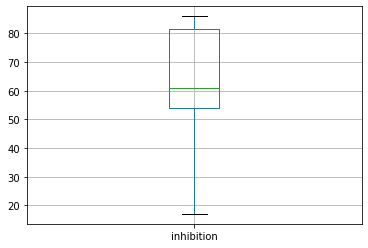

In [63]:
df_tmp1.boxplot('inhibition')


In [44]:
# find the ones passed filter but have low inhibition
print(df_tmp[df_tmp['inhibition']<25])

                      seq  inhibition   nm  num_A  num_C  num_G  num_T  \
3    TGGCAGATGCCTTGTCGGCA          21   75      3      5      7      5   
106  CTGCTTCTGGAGCTGGCTGA          17  100      2      5      7      6   

     cg_ratio  tm  LMNA_pos  LMNA_open_ratio  LMNA_open_len  posi  nega  
3         0.6  64      1781             0.35              5     0     0  
106       0.6  64       916             0.45              5     0     0  


### Pearson Correlation
following are Pearson correlation of each attribute with 'inhibiton'

In [16]:
print(df.corrwith(df['inhibition']))

inhibition         1.000000
nm                 0.468027
num_A              0.009650
num_C              0.250826
num_G             -0.234835
num_T              0.016441
cg_ratio          -0.024142
tm                -0.024142
LMNA_pos          -0.020738
LMNA_open_ratio    0.285091
LMNA_open_len      0.311361
posi              -0.096376
nega              -0.304351
dtype: float64


## Train
Try training with XGBoost
(the result is not so good)

In [74]:
# import random
# random_index = random.shuffle(range(0,100))
feature_cols = ['num_A','num_C','num_G','num_T','LMNA_open_ratio','LMNA_open_len','posi','nega','cg_ratio','nm']
xgb = XGBRegressor(learning_rate=0.5,
                    objective='reg:linear',
                    max_depth=17)
for k in range(5): # k-fold
    df_train,df_test = k_fold(5,k,df)
    xgb.fit(df_train[feature_cols],df_train['inhibition'])
    pred = xgb.predict(df_test[feature_cols])
    ms_error = mean_squared_error(pred,df_test['inhibition'])
    res = pd.DataFrame({'seq':df_test['seq'],'pred':pred,'label':df_test['inhibition']},columns=['seq','pred','label'])
    break
print(res)
print('Mean Squared Error:{}'.format(ms_error))

[16:44:03] WARNING: d:\bld\xgboost-split_1637426510059\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
                     seq       pred  label
0   GGGCTCTGGGCTCCTGAGCC  16.000090      3
1   CCGAGCTGCTGCAGTGGGAG  48.430969     42
2   GCAGGTCCCGCACAGCACGG  47.150051     61
3   TGGCAGATGCCTTGTCGGCA  39.664467     21
4   GAGCCGCTGGCAGATGCCTT  54.898422     24
5   CTGAGCCGCTGGCAGATGCC  51.643246     60
6   AGGAGATGGGTCCGCCCACC  52.314770     44
7   CAGAGGAGATGGGTCCGCCC  43.945030     38
8   GCCAGAGGAGATGGGTCCGC  49.706074     54
9   GAGCCAGAGGAGATGGGTCC  48.631226     43
10  TGGAGGCAGAAGAGCCAGAG  56.062592     50
11  ACACTGGAGGCAGAAGAGCC  60.844936     43
12  TGACACTGGAGGCAGAAGAG  52.564087     44
13  CCGTGACACTGGAGGCAGAA  57.698223     47
14  AGTGACCGTGACACTGGAGG  41.260647     69
15  CTGCGAGTGACCGTGACACT  31.300966     67
16  GGTAGCTGCGAGTGACCGTG  49.430294     71
17  TCTGGGTTCGGGGGCTGGAG  20.381416     54
18  GGCTCTGGGTTCGGGGGCTG  3